In [2]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# Defining the molecule names and HOMO-LUMO Gap
molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-12', 'AD-13', 'AD-13-DMF', 'AD-14-Moore', 'AD-15', 'AD-15-DMF', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-8', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 3.191, 3.226, 3.228, 2.811, 2.971, 2.813, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 2.97, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

CPU times: total: 31.2 ms
Wall time: 310 ms


In [3]:
# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'LUMO_calib_stds',
    'HOMO_calib', 'HOMO_calib_stds','GAP_calc', 'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

In [4]:
curcumin_variants_dict = {
    "curcumin_variant00": "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant01": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "curcumin_variant02": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant03": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "curcumin_variant04": "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "curcumin_variant05": "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "curcumin_variant06": "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "curcumin_variant07": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant08": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant09": "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant10": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant11": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant12": "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "curcumin_variant13": "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "curcumin_variant14": "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant15": "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant16": "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant17": "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant18": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant19": "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "curcumin_variant20": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "curcumin_variant21": "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant22": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant23": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "curcumin_variant24": "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "curcumin_variant25": "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
}

In [5]:
%%time
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import pandas as pd

# Dictionary to hold the dataframes
similarity_dfs = {}

# Function to calculate similarity
def calculate_similarity(fp1, fp2, metric="dice"):
    if metric == "dice":
        return DataStructs.DiceSimilarity(fp1, fp2)
    else:
        raise ValueError(f"Unknown similarity metric: {metric}")

print("Processing similarity dataframes...")

# Loop over curcumin variants and create similarity dataframes
for key, smiles in curcumin_variants_dict.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    specific_fp = AllChem.GetMorganFingerprintAsBitVect(specific_mol, 2, nBits=2048)

    # Calculate similarity and create a new dataframe with similarity scores
    opv_df_sim_segment = opv_df.copy()
    opv_df_sim_segment['mol'] = opv_df_sim_segment['smiles'].apply(Chem.MolFromSmiles)
    opv_df_sim_segment[f'similarity_{key}_morgan_dice'] = opv_df_sim_segment['mol'].apply(
        lambda x: calculate_similarity(AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048), specific_fp)
    )

    # Filter top 48% similar molecules
    quantile_value = opv_df_sim_segment[f'similarity_{key}_morgan_dice'].quantile(0.52)
    filtered_df = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_morgan_dice'] >= quantile_value]

    # Keep only the relevant columns (initial columns + similarity)
    filtered_df = filtered_df[['smiles', 'mol', 'GAP_calib', f'similarity_{key}_morgan_dice']]

    # Store the filtered dataframe in the dictionary
    similarity_dfs[f'{key}_morgan_dice'] = filtered_df

print("Done processing similarity dataframes.")

# Dictionary to store DataFrames with Morgan fingerprints
similarity_dfs_top48 = {}

print("Processing similarity dataframes with Morgan fingerprints...")

# Process each dataframe in the similarity_dfs dictionary
for key, df in similarity_dfs.items():
    # Generate Morgan fingerprints for the smiles in the dataframe
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    
    # Filter out rows where Morgan fingerprints could not be generated
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert the list of fingerprints into a DataFrame
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
    
    # Concatenate the original DataFrame with the Morgan fingerprints DataFrame
    df_mf = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the final DataFrame in the new dictionary
    similarity_dfs_top48[key] = df_mf
    
    print(f"Done processing {key} dataframe - shape {df_mf.shape}")

# Unpacking the dictionary to global variables
for curcumin_variant_key in similarity_dfs_top48.keys():
    globals()[f'similarity_dfs_top48_{curcumin_variant_key}'] = similarity_dfs_top48[curcumin_variant_key]

print("Done processing similarity dataframes with Morgan fingerprints.")

Processing similarity dataframes...
Done processing similarity dataframes.
Processing similarity dataframes with Morgan fingerprints...
Done processing curcumin_variant00_morgan_dice dataframe - shape (24708, 2052)
Done processing curcumin_variant01_morgan_dice dataframe - shape (24625, 2052)
Done processing curcumin_variant02_morgan_dice dataframe - shape (24714, 2052)
Done processing curcumin_variant03_morgan_dice dataframe - shape (25010, 2052)
Done processing curcumin_variant04_morgan_dice dataframe - shape (25257, 2052)
Done processing curcumin_variant05_morgan_dice dataframe - shape (24796, 2052)
Done processing curcumin_variant06_morgan_dice dataframe - shape (24628, 2052)
Done processing curcumin_variant07_morgan_dice dataframe - shape (24611, 2052)
Done processing curcumin_variant08_morgan_dice dataframe - shape (24611, 2052)
Done processing curcumin_variant09_morgan_dice dataframe - shape (25344, 2052)
Done processing curcumin_variant10_morgan_dice dataframe - shape (24976, 2

In [6]:
%%time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd

# Curcumin variants dictionary
curcumin_variants_dict = {
    "curcumin_variant00": "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant01": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "curcumin_variant02": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant03": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "curcumin_variant04": "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "curcumin_variant05": "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "curcumin_variant06": "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "curcumin_variant07": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant08": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant09": "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant10": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant11": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant12": "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "curcumin_variant13": "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "curcumin_variant14": "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant15": "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant16": "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant17": "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant18": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant19": "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "curcumin_variant20": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "curcumin_variant21": "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant22": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant23": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "curcumin_variant24": "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "curcumin_variant25": "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
}

# Define the similarity method and curcumin variants
similarity_method = 'morgan_dice'
curcumin_variants = list(curcumin_variants_dict.keys())

# Create a list of tuples for dataframes using the chosen similarity method
dataframes = [
    (f'similarity_dfs_top48_{variant}_{similarity_method}', globals()[f'similarity_dfs_top48_{variant}_{similarity_method}'])
    for variant in curcumin_variants
]

# Define the LightGBM model with the specified parameters
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
lgb_model = lgb.LGBMRegressor(**tuned_params)

results = []
best_models = {}  # Dictionary to store the best models by variant name

for name, df in dataframes:
    print(f"Processing {name}...")
    X = df.iloc[:, 4:]
    y = df['GAP_calib']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    # Store the model and its R2 score
    best_models[name] = lgb_model
    results.append({'variant': name, 'r2_score': r2})

    print(f"Done processing {name} with R2 score: {r2:.4f}")

# Convert results to a DataFrame
final_results_top48 = pd.DataFrame(results)

# Display the first few rows of the final results
final_results_top48.head()

Processing similarity_dfs_top48_curcumin_variant00_morgan_dice...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 18531, number of used features: 1290
[LightGBM] [Info] Start training from score 2.779891
Done processing similarity_dfs_top48_curcumin_variant00_morgan_dice with R2 score: 0.9456
Processing similarity_dfs_top48_curcumin_variant01_morgan_dice...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 18468, number of used features: 1283
[LightGBM] [Inf

,variant,r2_score
0,similarity_dfs_top48_curcumin_variant00_morgan...,0.945646
1,similarity_dfs_top48_curcumin_variant01_morgan...,0.947632
2,similarity_dfs_top48_curcumin_variant02_morgan...,0.947148
3,similarity_dfs_top48_curcumin_variant03_morgan...,0.930341
4,similarity_dfs_top48_curcumin_variant04_morgan...,0.927627


In [7]:
# Extract index from the variant column in final_results_top48
final_results_top48['index'] = final_results_top48['variant'].apply(
    lambda x: int(x.split('variant')[1].split('_')[0])
)

# Map the Molecule column from curcumin_df_mf based on the extracted index
final_results_top48['Molecule'] = final_results_top48['index'].map(
    curcumin_df_mf.set_index(curcumin_df_mf.index)['Molecule']
)

# Drop the temporary index column if not needed
final_results_top48.drop(columns=['index'], inplace=True)

# Display the updated dataframe
final_results_top48

,variant,r2_score,Molecule
0,similarity_dfs_top48_curcumin_variant00_morgan...,0.945646,2-ADMeO3
1,similarity_dfs_top48_curcumin_variant01_morgan...,0.947632,3-MR83a
2,similarity_dfs_top48_curcumin_variant02_morgan...,0.947148,AD-10
3,similarity_dfs_top48_curcumin_variant03_morgan...,0.930341,AD-1013
4,similarity_dfs_top48_curcumin_variant04_morgan...,0.927627,AD-1022
5,similarity_dfs_top48_curcumin_variant05_morgan...,0.939201,AD-11
6,similarity_dfs_top48_curcumin_variant06_morgan...,0.930927,AD-12
7,similarity_dfs_top48_curcumin_variant07_morgan...,0.937779,AD-13
8,similarity_dfs_top48_curcumin_variant08_morgan...,0.937779,AD-13-DMF
9,similarity_dfs_top48_curcumin_variant09_morgan...,0.935306,AD-14-Moore


In [8]:
import plotly.express as px
import pandas as pd

# Create the bar plot
fig = px.bar(final_results_top48, x='Molecule', y='r2_score', title='Molecule vs R2 Score',
             labels={'r2_score': 'R2 Score', 'Molecule': 'Molecule'},
             text=final_results_top48['r2_score'].round(4))

# Update layout for better readability
fig.update_layout(
    xaxis_title='Molecule',
    yaxis_title='R2 Score',
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 1]),
    height = 800
)

# Display the plot
fig.show()


In [21]:
import plotly.graph_objects as go
import pandas as pd

# Identify top 3 models by highest r2_score
top_3_indices = final_results_top48.nlargest(3, 'r2_score').index
final_results_top48['Rank'] = final_results_top48.index.map(lambda idx: 'Top 1' if idx == top_3_indices[0] 
                                                                else 'Top 2' if idx == top_3_indices[1]
                                                                else 'Top 3' if idx == top_3_indices[2]
                                                                else '')

# Create a bar plot
fig = go.Figure()

# Add bars for each Molecule
fig.add_trace(go.Bar(
    x=final_results_top48['Molecule'],
    y=final_results_top48['r2_score'],
    text=final_results_top48.apply(lambda row: f"{row['Rank']}<br>R2: {row['r2_score']:.4f}" if row['Rank'] else f"R2: {row['r2_score']:.4f}", axis=1),
    textposition='auto',
    marker=dict(color=[
        'maroon' if row['Rank'] == 'Top 1' else 
        'gold' if row['Rank'] == 'Top 2' else 
        'orange' if row['Rank'] == 'Top 3' else 
        'navy' 
        for index, row in final_results_top48.iterrows()
    ]),
    name='Models'
))

# Add annotations for the top 3 models
for idx in top_3_indices:
    row = final_results_top48.loc[idx]
    if row['Rank'] == 'Top 1':
        ax_value = 50
    elif row['Rank'] == 'Top 2':
        ax_value = 200
    elif row['Rank'] == 'Top 3':
        ax_value = 0

    fig.add_annotation(
        x=row['Molecule'],
        y=row['r2_score'],
        text=f"{row['Rank']}: {row['Molecule']}<br>R2: {row['r2_score']:.4f}",
        showarrow=True,
        arrowhead=2,
        ax=ax_value,
        ay=-50,
        font=dict(size=12),
        align='center'
    )

# Update layout
fig.update_layout(
    title= 'Curcumin Derivative filtered dataframe Trained Model Performances',
    xaxis_title='Curcumin Derivative Molecule Name',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    xaxis_tickangle=-45,
    height=800,
    width=1100,
    legend_title='Top Models',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.05,
        xanchor='center',
        x=0.5
    ),
    margin=dict(l=100, r=100, t=100, b=50)
)

# Show the plot
fig.show()

In [40]:
import plotly.graph_objects as go

# Sort by r2_score in descending order to find the best 3 variants
top_3_df = final_results_top48.sort_values(by='r2_score', ascending=False).head(3)

# Create the bar chart
fig = go.Figure()

# Add bars
fig.add_trace(go.Bar(
    x=final_results_top48['Molecule'],
    y=final_results_top48['r2_score'],
    text=final_results_top48['r2_score'].apply(lambda x: f"{x:.5f}"),
    textposition='inside',
    marker=dict(color='lightblue', opacity=0.6)
))

# Define a list of colors or use a color scale
color_scale = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'grey', 'brown']

# Annotate the top 3 variants with different colors
for idx, row in top_3_df.iterrows():
    color = color_scale[idx % len(color_scale)]  # Use modulo to avoid index out of range
    fig.add_trace(go.Scatter(
        x=[row['Molecule']],
        y=[row['r2_score']],
        mode='markers+text',
        marker=dict(size=12, color=color, line=dict(width=2, color='Black')),
        text=f"{row['Molecule']}<br>R2: {row['r2_score']:.5f}",
        textposition='top center',
        name=f"Top {idx+1} Variant"
    ))

    # Add annotation with an arrow
    fig.add_annotation(
        x=row['Molecule'],
        y=row['r2_score'],
        text=f"{row['Molecule']}<br>R2: {row['r2_score']:.5f}",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        arrowcolor=color
    )

# Update layout
fig.update_layout(
    title='Molecule vs R2 Score',
    xaxis_title='Molecule',
    yaxis_title='R2 Score',
    xaxis_tickangle=-45,
    yaxis=dict(range=[0, 1]),  # Adjust range as needed
    template='plotly_white',
    height = 800,
    width = 1100
)

# Show the plot
fig.show()

In [22]:
# Initialize an empty list to store the predicted energy gaps
predicted_energy_gaps = []

# Iterate through each row in the curcumin_df_mf
for index, row in curcumin_df_mf.iterrows():
    # Extract the variant number from the index
    variant_number = f'{index:02d}'  # Format index to match the two-digit variant in model names
    
    # Construct the model key using the variant number
    model_key = f'similarity_dfs_top48_curcumin_variant{variant_number}_morgan_dice'
    
    # Get the corresponding model from the best_models dictionary
    model = best_models.get(model_key)
    
    if model is not None:
        # Extract the fingerprint data (last 2048 columns)
        fingerprint_data = row.iloc[-2048:].values.reshape(1, -1)
        
        # Predict the energy gap using the model
        energy_gap = model.predict(fingerprint_data)[0]
        predicted_energy_gaps.append(energy_gap)
    else:
        # If no model is found, append None
        predicted_energy_gaps.append(None)

# Add the predictions as a new column to curcumin_df_mf
curcumin_df_mf['Homo-Lumo Gap (eV) Predicted'] = predicted_energy_gaps

# Display the updated dataframe
curcumin_df_mf

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047,Homo-Lumo Gap (eV) Predicted
0,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.364453
1,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.226149
2,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.944993
3,AD-1013,482.335,7.29270,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.016535
4,AD-1022,472.293,5.01210,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.958797
5,AD-11,444.239,4.40610,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.065937
6,AD-12,509.981,6.50270,3.191,F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.324388
7,AD-13,464.317,6.21190,3.226,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.187243
8,AD-13-DMF,464.317,6.21190,3.228,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.187243
9,AD-14-Moore,438.327,5.10970,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.193340


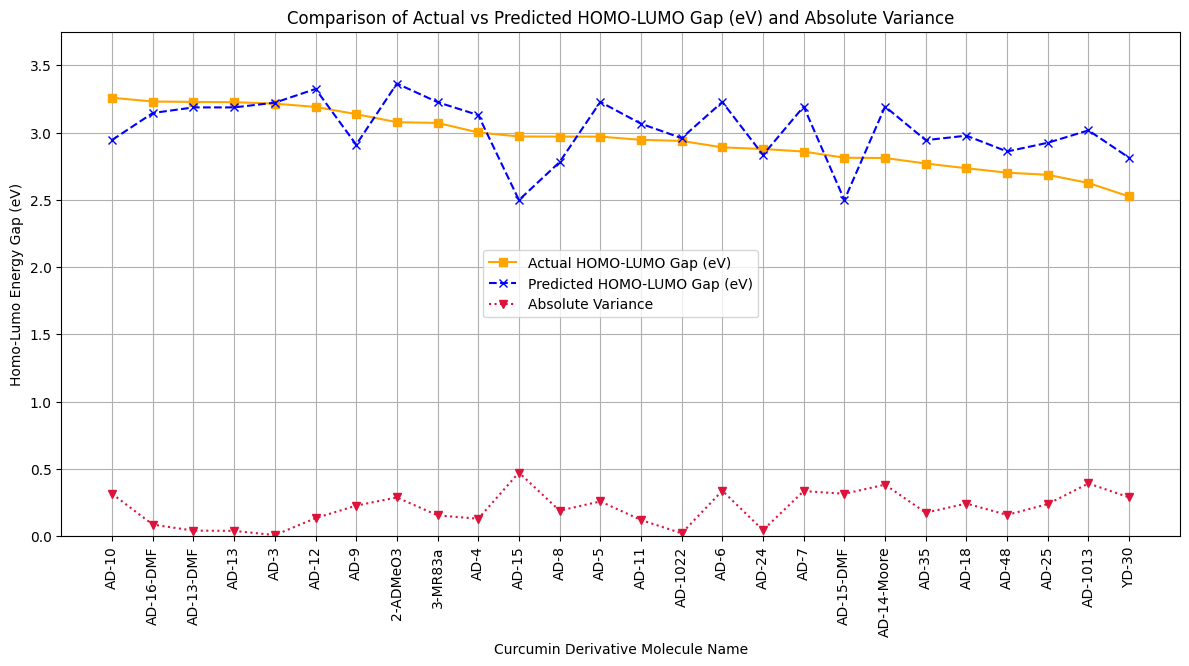

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming curcumin_df_mf already has a 'Homo-Lumo Gap (eV) Predicted' column from the previous steps

# Sort curcumin_df_mf by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Predicted'
curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Predicted']).abs()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['Homo-Lumo Gap (eV) Predicted'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Homo-Lumo Energy Gap (eV)')
ax1.set_ylim([0, 3.75])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance')
plt.grid(True)
plt.legend(loc='center')
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

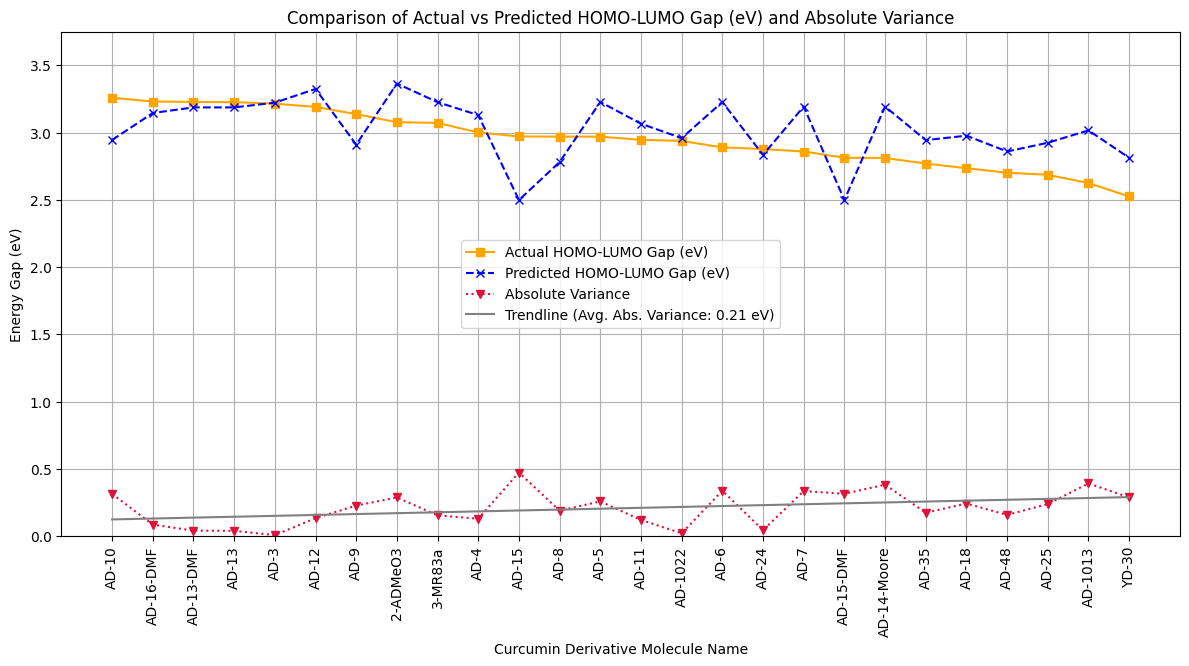

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming curcumin_df_mf already has a 'Homo-Lumo Gap (eV) Predicted' column from the previous steps

# Sort curcumin_df_mf by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Predicted'
curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Predicted']).abs()

# Calculate linear trendline for absolute variance
x = curcumin_df_mf.index
y = curcumin_df_mf['absolute_variance']
coefficients = np.polyfit(x, y, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x)

# Calculate the average absolute variance
average_variance = y.mean()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['Homo-Lumo Gap (eV) Predicted'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf['Molecule'], curcumin_df_mf['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot the trendline for absolute variance
ax1.plot(curcumin_df_mf['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 3.75])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='center')

# Customize the plot
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [33]:
from sklearn.metrics import r2_score, mean_squared_error
overall_r2 = r2_score(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Predicted'])
overall_rmse = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Predicted'])
print(f"Overall R² score: {overall_r2:.5f}")
print(f"Overall RMSE value: {overall_rmse:.5f}")

Overall R² score: -0.41188
Overall RMSE value: 0.05851


In [75]:
import plotly.graph_objects as go

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for similarity_method in final_results_top30['Fingerprint type'].unique():
    filtered_df = final_results_top30[final_results_top30['Fingerprint type'] == similarity_method]
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=similarity_method,
        text=filtered_df['r2_score'].round(4),
        textposition='auto'
    ))

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=800,
    width=970,
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

In [35]:
import plotly.graph_objects as go

# Find the best model and fingerprint type
best_row = final_results_top30.loc[final_results_top30['r2_score'].idxmax()]
best_similarity_method = best_row['Similarity Method']
best_fingerprint_type = best_row['Fingerprint type']
best_r2 = best_row['r2_score']

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for fingerprint_type in final_results_top30['Fingerprint type'].unique():
    filtered_df = final_results_top30[final_results_top30['Fingerprint type'] == fingerprint_type]
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=fingerprint_type,
        text=filtered_df['r2_score'].round(4),
        textposition='auto',
        marker=dict(color=['red' if (row['Similarity Method'] == best_similarity_method and row['Fingerprint type'] == best_fingerprint_type) else 'blue' for index, row in filtered_df.iterrows()])
    ))

# Add annotation for the best model
fig.add_annotation(
    x=best_similarity_method,
    y=best_r2,
    text=f"Best: {best_similarity_method}<br>Fingerprint: {best_fingerprint_type}<br>R2: {best_r2:.4f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=600,
    width=1150
)

# Show the plot
fig.show()

In [79]:
import plotly.graph_objects as go

# Sort the dataframe by R2 score and label Best 1, Best 2, Best 3
sorted_df = final_results_top30.sort_values(by='r2_score', ascending=False).reset_index(drop=True)
sorted_df['Rank'] = ['Best 1', 'Best 2', 'Best 3'] + [''] * (len(sorted_df) - 3)

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for fingerprint_type in final_results_top30['Fingerprint type'].unique():
    filtered_df = sorted_df[sorted_df['Fingerprint type'] == fingerprint_type]
    
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=fingerprint_type,
        text=filtered_df.apply(lambda row: f"{row['Rank']}<br>R2: {row['r2_score']:.4f}" if row['Rank'] else f"R2: {row['r2_score']:.4f}", axis=1),
        textposition='auto',
        showlegend=False,
        marker=dict(color=[
            'red' if row['Rank'] == 'Best 1' else 
            'green' if row['Rank'] == 'Best 2' else 
            'orange' if row['Rank'] == 'Best 3' else 
            'blue' 
            for index, row in filtered_df.iterrows()
        ])
    ))

# Add annotations for the top 3 models
for i, row in sorted_df.head(3).iterrows():
    fig.add_annotation(
        x=row['Similarity Method'],
        y=row['r2_score'],
        text=f"{row['Rank']}: {row['Similarity Method']}<br>Fingerprint: {row['Fingerprint type']}<br>R2: {row['r2_score']:.4f}",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint Type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=800,
    width=1100
)

# Show the plot
fig.show()

In [103]:
curcumin_df_mf = curcumin_df.copy()
curcumin_df_mf['Morgan_Fingerprints'] = curcumin_df_mf['mol'].apply(
    lambda x: list(AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048))
)
curcumin_df_mf.head()

# convert the fingerprints to a DataFrame
morgan_df = pd.DataFrame(curcumin_df_mf['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
curcumin_df_mf = pd.concat([curcumin_df_mf.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
curcumin_df_mf.head()

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,mol,morgan_0,morgan_1,morgan_2,morgan_3,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x000002C5337...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x000002C5546...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-13-DMF,464.317,6.21190,3.228,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,<rdkit.Chem.rdchem.Mol object at 0x000002C5544...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-13,464.317,6.21190,3.226,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,<rdkit.Chem.rdchem.Mol object at 0x000002C5337...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-3,402.209,4.72106,3.215,N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x000002C5546...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
x = similarity_dfs_similarity_morgan_dice_top30.iloc[:, 4:]
y = similarity_dfs_similarity_morgan_dice_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_morgan_dice R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_morgan_dice model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 11690, number of used features: 1151
[LightGBM] [Info] Start training from score 2.764779
Model similarity_morgan_dice R2 Score: 0.9398020190041924 & RMSE value: 0.14614475789047782
Prediction with similarity_morgan_dice model R2 Score: -0.42051782594244336 & RMSE value: 0.058863854753810944


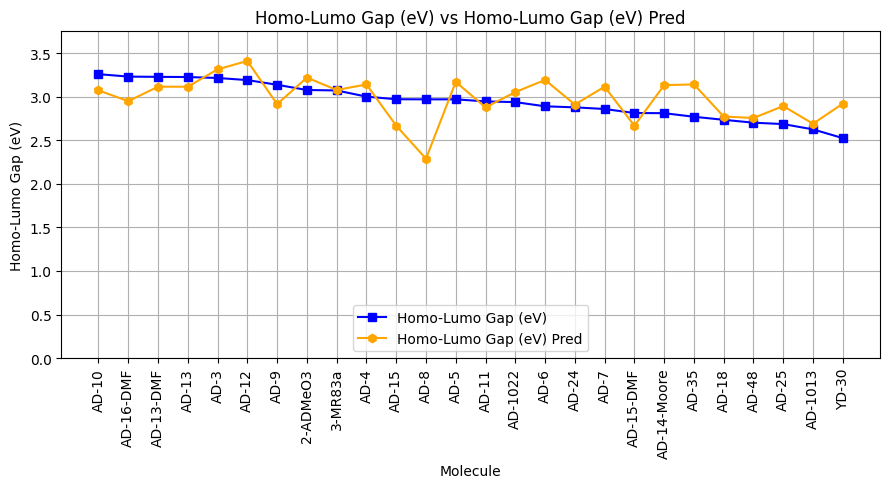

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Homo-Lumo Gap (eV)', color='blue')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='h', label=f'Homo-Lumo Gap (eV) Pred', color='orange')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.legend(loc='lower center')
plt.ylim(0, 3.75)
plt.xticks(rotation=90)
plt.show()

In [111]:
x = similarity_dfs_similarity_morgan_tanimoto_top30.iloc[:, 4:]
y = similarity_dfs_similarity_morgan_tanimoto_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_morgan_tanimoto R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_morgan_tanimoto model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 11690, number of used features: 1151
[LightGBM] [Info] Start training from score 2.764779
Model similarity_morgan_tanimoto R2 Score: 0.9398020190041924 & RMSE value: 0.14614475789047782
Prediction with similarity_morgan_tanimoto model R2 Score: -0.42051782594244336 & RMSE value: 0.058863854753810944


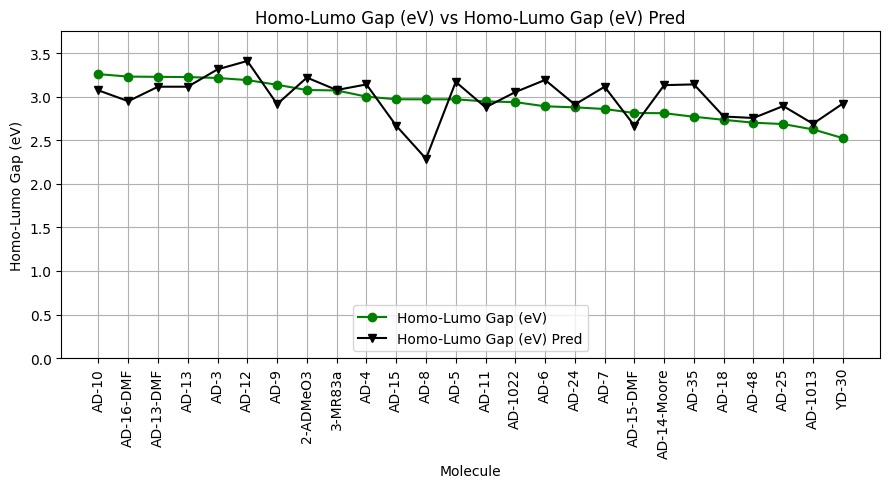

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='o', label='Homo-Lumo Gap (eV)', color='green')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='v', label=f'Homo-Lumo Gap (eV) Pred', color='black')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.ylim(0, 3.75)
plt.legend(loc='lower center')
plt.xticks(rotation=90)
plt.show()

In [113]:
x = similarity_dfs_similarity_maccs_kulczynski_top30.iloc[:, 4:]
y = similarity_dfs_similarity_maccs_kulczynski_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_maccs_kulczynski R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_maccs_kulczynski model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 11697, number of used features: 1139
[LightGBM] [Info] Start training from score 2.777426
Model similarity_maccs_kulczynski R2 Score: 0.9364081010414715 & RMSE value: 0.14527166736579736
Prediction with similarity_maccs_kulczynski model R2 Score: -2.3031114967937163 & RMSE value: 0.136875350546137


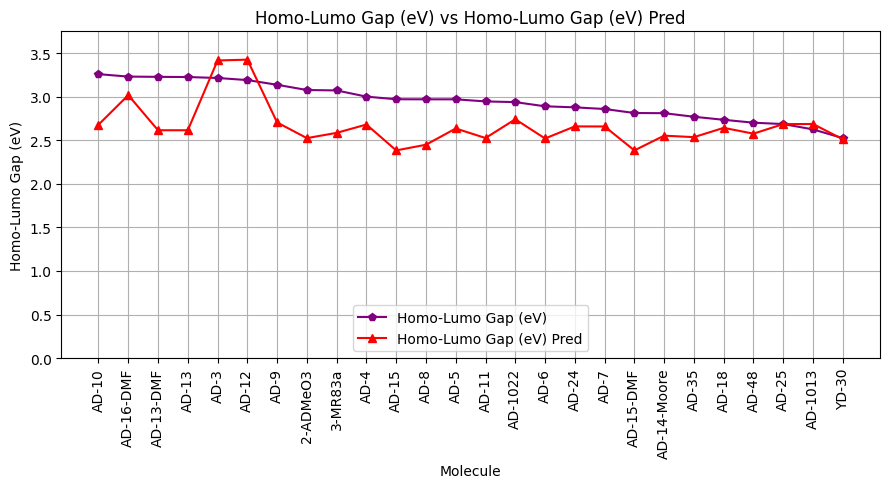

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='p', label='Homo-Lumo Gap (eV)', color='purple')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='^', label=f'Homo-Lumo Gap (eV) Pred', color='red')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.ylim(0, 3.75)
plt.legend(loc='lower center')
plt.xticks(rotation=90)
plt.show()